In [1]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML

In [2]:
A = np.array(
    [[0, 1, 0, 0, 0], [1, 0, 1, 0, 0], [0, 1, 0, 1, 1], [0, 0, 1, 0, 0], [0, 0, 1, 0, 0]]
)
A.shape
A

array([[0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0],
       [0, 1, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [3]:
feats = np.arange(A.shape[0]).reshape((-1,1))+1
feats

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [4]:
feats_2d = np.random.randint(low=0, high=10, size=(5,2))
feats_2d

array([[3, 1],
       [0, 0],
       [1, 8],
       [4, 7],
       [2, 1]])

In [5]:
feats_2d.shape

(5, 2)

In [7]:
H = A @ feats
H

array([[ 2],
       [ 4],
       [11],
       [ 3],
       [ 3]])

In [7]:
H2 = A @ feats_2d
H2

array([[ 6,  8],
       [ 5, 17],
       [ 7, 18],
       [ 5,  9],
       [ 5,  9]])

#### Result of message passing

$H$ and $H_{2}$ represent the sum of the connected neighborhs

Other aggration functions can be used:

$D \rightarrow$ Degree matrix, same size of $A$ but with neighbor size of each node in diagonal


In [8]:
row_sum = A.sum(axis=1).reshape(-1,1)
row_sum

array([[1],
       [2],
       [3],
       [1],
       [1]])

In [9]:
D = np.eye(A.shape[0],A.shape[1]) * row_sum
D

array([[1., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 3., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [10]:
D = np.zeros(A.shape)
np.fill_diagonal(D, A.sum(axis=0))
D

array([[1., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0.],
       [0., 0., 3., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [11]:
D_inv = np.linalg.inv(D)
D_inv

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In order to get Average of each row, we can multiply $D^{-1}$ by the adjacency matrix $A$:

 $D^{-1}.A = A_{avg}$

In [13]:
D_inv @ A

array([[0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ]])

Now if we used the scaled adjacency matrix $A_{avg}$ to multiply the features, we will get the average feature of each node (another way to aggreagate nodes instead of sum)

In [18]:
H = D_inv @ A @ feats
H

array([[2.        ],
       [2.        ],
       [3.66666667],
       [3.        ],
       [3.        ]])

## Normalized Adjacency Matrix $\hat{A}$

- Adding self-connections to adjacency matrix
- If include self connection, we include the node itself in the aggregation (comes from the derivation of convolution on graph see paper for derivation)

In [19]:
A_self = np.eye(A.shape[0],A.shape[1])
A_self

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [20]:
A_tilde = A_self + A
A_tilde

array([[1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 1.]])

In [21]:
g = nx.from_numpy_array(A)
pos = nx.planar_layout(g)
node_labels = {i: i+1 for i in range(g.number_of_nodes())}

In [22]:
nx.is_eulerian(g)

False

In [23]:
node_labels

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5}

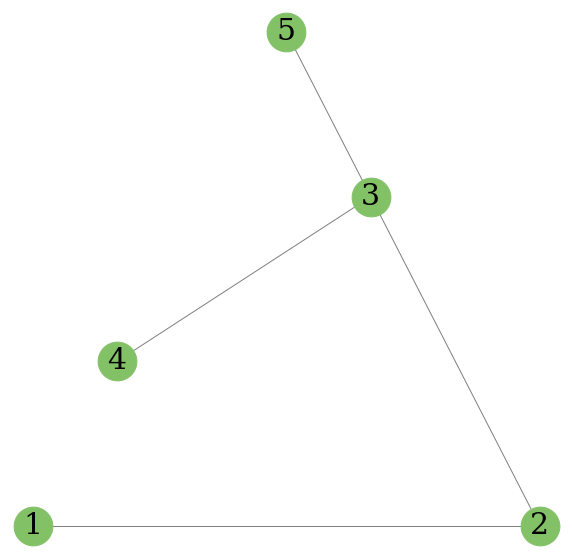

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(
    g, pos, with_labels=True, 
    labels=node_labels, 
    node_color='#83C167', 
    ax=ax, edge_color='gray', node_size=1500, font_size=30, font_family='serif'
)

$
\hat{A} = \tilde{D}^{-1/2} \; \tilde{A} \; \tilde{D}^{-1/2}
$

or put differently, normalize connections on the adjacency matrix but using connections of both source and destination nodes

For a particular value in the adjecenty matrix:  
$
\hat{A}_{i,j} = \frac{1}{\sqrt{\tilde{d}_{i}\tilde{d}_{j}}} \tilde{A}_{i,j} 
$

In [25]:
D = np.zeros(A_tilde.shape)
np.fill_diagonal(D, A_tilde.sum(axis=0))
# D_inv = np.linalg.inv(D)
# D_inv
D_tilde = np.linalg.inv(sqrtm(D))
D_tilde

array([[0.70710678, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.70710678, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.70710678]])

In [28]:
A_hat = D_tilde @ A_tilde @ D_tilde
A_hat.shape

(5, 5)

In [29]:
A_hat.flatten()

array([0.5       , 0.40824829, 0.        , 0.        , 0.        ,
       0.40824829, 0.33333333, 0.28867513, 0.        , 0.        ,
       0.        , 0.28867513, 0.25      , 0.35355339, 0.35355339,
       0.        , 0.        , 0.35355339, 0.5       , 0.        ,
       0.        , 0.        , 0.35355339, 0.        , 0.5       ])

## Water Drop Experiment

In [38]:
H = np.zeros((g.number_of_nodes(), 1))
H[0,0] = 20 # the "water drop"
#H[-1,0] = -2
## 
iters = 20
results = [H.flatten()]
print(f"Initial Matrix H \n{H}")
print("-"*30)
for i in range(iters):
    H = A_hat @ H
    results.append(H.flatten())
    if i%5 ==0:
        print(f"Iteration \n{i}")
        print(f"Matrix H \n{H}")
        print("-"*30)

Initial Matrix H 
[[20.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
------------------------------
Iteration 
0
Matrix H 
[[10.        ]
 [ 8.16496581]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
------------------------------
Iteration 
5
Matrix H 
[[4.82317387]
 [4.90241831]
 [3.5840702 ]
 [2.05198688]
 [2.05198688]]
------------------------------
Iteration 
10
Matrix H 
[[3.5357773 ]
 [4.06686307]
 [4.14925521]
 [2.80771001]
 [2.80771001]]
------------------------------
Iteration 
15
Matrix H 
[[3.19754058]
 [3.84688898]
 [4.2982832 ]
 [3.00615574]
 [3.00615574]]
------------------------------


In [31]:
results[0].min(), results[0].max()

(0.0, 20.0)

In [32]:
print(f"Initial signal input: \n{results[0]}")
print(f"Final signal output after running {iters} steps of message-passing:  \n{results[-1]}")

Initial signal input: 
[20.  0.  0.  0.  0.]
Final signal output after running 20 steps of message-passing:  
[3.11834192 3.79538238 4.33317752 3.05262228 3.05262228]


In [33]:
results[-1]

array([3.11834192, 3.79538238, 4.33317752, 3.05262228, 3.05262228])

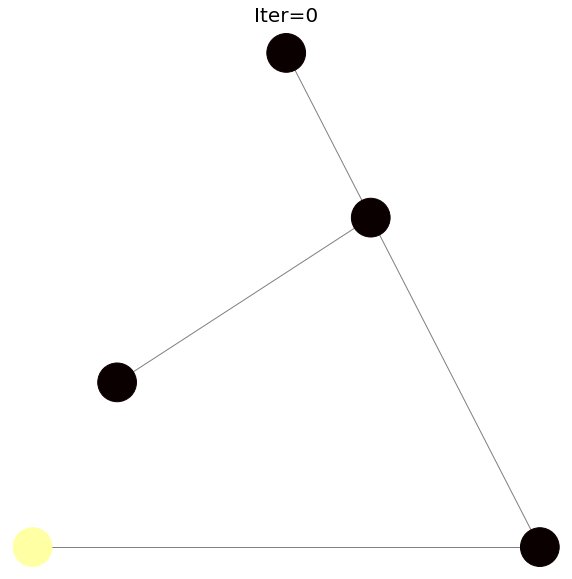

In [34]:

fig, ax = plt.subplots(figsize=(10, 10))

kwargs = {'cmap': 'hot', 'node_size': 1500, 'edge_color': 'gray', 
          'vmin': np.array(results).min(), 'vmax': np.array(results).max()*1.1}

def update(idx):
    ax.clear()
    colors = results[idx]
    nx.draw(g, pos, node_color=colors, ax=ax, **kwargs)
    ax.set_title(f"Iter={idx}", fontsize=20)

anim = animation.FuncAnimation(fig, update, frames=len(results), interval=1000, repeat=True)

In [ ]:
# anim.save(
#     'water_drop.gif', 
#     writer='PillowWriter', 
#     fps=2,
#     savefig_kwargs={'transparent': True, 'facecolor': 'none'},
# )

In [35]:
anim.save(
    'water_drop.mp4', 
    dpi=600, bitrate=-1,
    savefig_kwargs={'transparent': True, 'facecolor': 'none'},
)

In [36]:
!ls

1.label_propagation.ipynb        sbm.gpickle
2.embeddings_benchmark_GEM.ipynb sbm_node_labels.pickle
3.graph_jazz_embeddings.ipynb    water_drop.gif
4.spectral_clustering.ipynb      water_drop.mp4
5.gcn_message_passing.ipynb      water_drop_2.mp4
6.gcn_paper.ipynb                water_drop_3.mp4
karate.edgelist                  water_drop_4.mp4
requirements.txt


In [37]:
HTML(anim.to_html5_video())


## Playing w/ NX

In [39]:
num_nodes = 10
edge_list = [
    [4], #1
    [5], #2
    [4], #3
    [1,3,5,6], #4
    [4], #5
    [4,7], #6
    [8], #7
    [7, 9, 10], #8
    [8], #9
    [8] #19
]

In [40]:
G = nx.make_small_graph(
    ["adjacencylist", "C_4", num_nodes, edge_list]
)
A = nx.adjacency_matrix(G).todense()

## Layout Types

- [Source](https://networkx.org/documentation/latest/_modules/networkx/drawing/layout.html)
```
    "bipartite_layout",
    "circular_layout",
    "kamada_kawai_layout",
    "random_layout",
    "rescale_layout",
    "rescale_layout_dict",
    "shell_layout",
    "spring_layout",
    "spectral_layout",
    "planar_layout",
    "fruchterman_reingold_layout",
    "spiral_layout",
    "multipartite_layout"
```

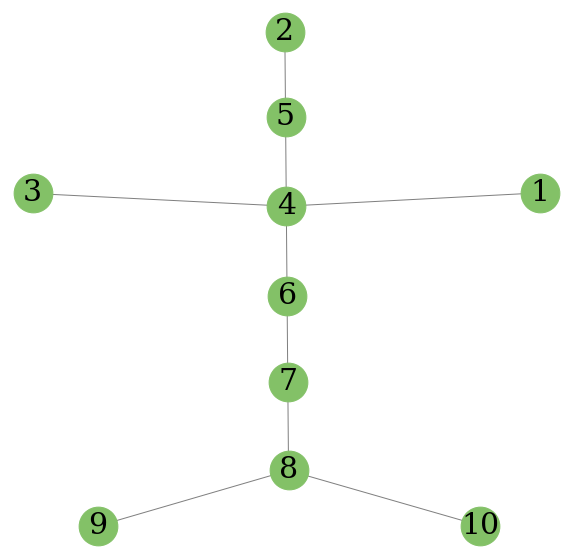

In [41]:
pos = nx.kamada_kawai_layout(G)
node_labels = {i: i+1 for i in range(G.number_of_nodes())}
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, pos, with_labels=True, 
    labels=node_labels, 
    node_color='#83C167', 
    ax=ax, edge_color='gray', node_size=1500, font_size=30, font_family='serif'
)

In [77]:
## Prepare A_tilde
λ = 2
A_self = np.eye(A.shape[0],A.shape[1])
A_tilde = A + λ*A_self
A_tilde

matrix([[2., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 2., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 2., 1., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 2., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 2., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 2., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 2., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 2.]])

In [78]:
## Prepare D_tilde
D = np.zeros(A_tilde.shape)
np.fill_diagonal(D, A_tilde.sum(axis=0))
D_tilde = np.linalg.inv(sqrtm(D))
D_tilde

array([[0.57735027, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.57735027, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.40824829, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.5       ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [79]:
A_hat = D_tilde @ A_tilde @ D_tilde
A_hat.shape

(10, 10)

In [80]:
## Water Droping
H = np.zeros((G.number_of_nodes(), 1))
H[1,0] = 10 # the "water drop"
# H[5,0] = 1
# H[-2,0] = 1
##
iters = 30
results = [np.array(H.flatten())]
print(f"Initial Matrix H \n{H}")
print("-"*30)
for i in range(iters):
    H = A_hat @ H
    results.append(np.array(H.flatten()))
    if i%10 ==0:
        print(f"Iteration \n{i}")
        print(f"Matrix H \n{H}")
        print("-"*30)

Initial Matrix H 
[[ 0.]
 [10.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
------------------------------
Iteration 
0
Matrix H 
[[0.        ]
 [6.66666667]
 [0.        ]
 [0.        ]
 [2.88675135]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
------------------------------
Iteration 
10
Matrix H 
[[0.9478365 ]
 [2.15573815]
 [0.9478365 ]
 [1.48899786]
 [2.03519495]
 [0.71353735]
 [0.34594487]
 [0.12940439]
 [0.05117107]
 [0.05117107]]
------------------------------
Iteration 
20
Matrix H 
[[1.0629903 ]
 [1.38289856]
 [1.0629903 ]
 [1.48742381]
 [1.46690856]
 [0.88941935]
 [0.58772659]
 [0.3888905 ]
 [0.24301457]
 [0.24301457]]
------------------------------


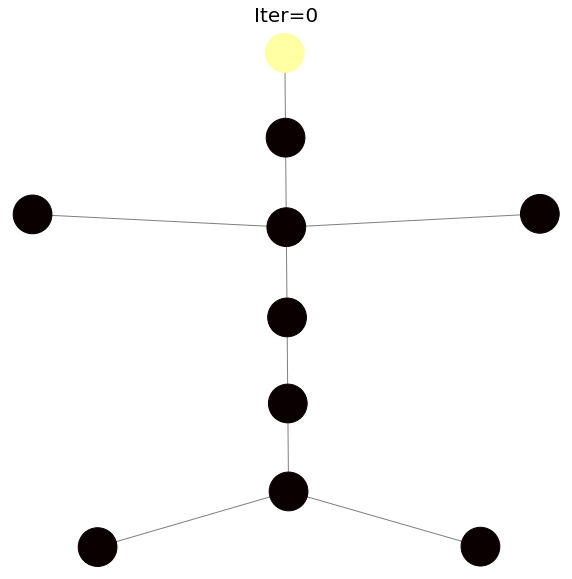

In [81]:
all_results = np.vstack((results))
fig, ax = plt.subplots(figsize=(10, 10))

kwargs = {'cmap': 'hot', 'node_size': 1500, 'edge_color': 'gray', 
          'vmin':all_results.min(), 'vmax': all_results.max()*1.1}
def update(idx):
    ax.clear()
    colors = results[idx]
    nx.draw(G, pos, node_color=colors, ax=ax, **kwargs)
    ax.set_title(f"Iter={idx}", fontsize=20)

anim = animation.FuncAnimation(fig, update, frames=len(results), interval=1000, repeat=True)

In [82]:
anim.save(
    'water_drop.gif', 
    writer='PillowWriter', 
    fps=2,
    savefig_kwargs={'transparent': True, 'facecolor': 'none'},
)

MovieWriter PillowWriter unavailable; using Pillow instead.


In [83]:
# anim.save(
#     'water_drop_4.mp4', 
#     dpi=600, bitrate=-1,
#     savefig_kwargs={'transparent': True, 'facecolor': 'none'},
# )

In [84]:
HTML(anim.to_html5_video())